In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

In [2]:
#!pip install pandas
#!pip install scikit-learn==1.5

In [20]:
#monday
#load df
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

#remove rows with missing target: D3_within12months
X.dropna(axis=0, subset=['D3_within12months'], inplace=True)
y = X.D3_within12months
X.drop(['D3_within12months', 'loan_account_no'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=11, stratify = y)
object_columns = X.select_dtypes(include=['object','category']).columns
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output = False,drop='first').set_output(transform='pandas')

one_hot_encoded_object_X_train = ohe.fit_transform(X_train[object_columns])
one_hot_encoded_object_X_test = ohe.transform(X_test[object_columns])

final_X_train = pd.concat([one_hot_encoded_object_X_train, X_train.select_dtypes('number')], axis=1)
final_X_test = pd.concat([one_hot_encoded_object_X_test, X_test.select_dtypes('number')], axis=1)

X_train = final_X_train
X_test = final_X_test

In [21]:
print(f'Done loading {segment}')

Done loading high_CIBIL


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
#!pip install xgboost

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the model
mod = "XGB"
xgb_model = XGBClassifier()

# Define the parameter distributions
param_distributions = {
    'n_estimators': randint(50,500),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.00001, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),  
    'colsample_bylevel': uniform(0.5, 0.5),  
    'min_child_weight': randint(1, 200),  
    'gamma': uniform(0.0, 15.0),
    'reg_alpha': randint(0.0, 15), 
    'reg_lambda': randint(0.0, 100),
    'eta': uniform(0.01, 0.2),
    'random_state' : [42],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up the random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, 
                                   n_iter=12, scoring='roc_auc', cv=cv, verbose=1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

cross_valid = pd.DataFrame(random_search.cv_results_)
cv_results_columns = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
                      'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
cross_valid[cv_results_columns].to_csv(f'./CV_tables/cvtable{mod}_{segment}.csv', index = False)

# Best parameters
print(f'Best parameters found {segment}: ', random_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found NTC:  {'colsample_bylevel': 0.9299702033681603, 'colsample_bytree': 0.8721230154351118, 'eta': 0.1000998503939086, 'gamma': 0.19897441739799793, 'learning_rate': 0.28267052670545584, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 395, 'random_state': 42, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.8736932106048627}


In [6]:
#jied
def xgbc_model_builder3(n_estimators = 100,
                          max_depth = 6,
                          learning_rate=0.3,
                          subsample = 1,
                          colsample_bytree = 1,
                          colsample_bylevel = 1,
                          min_child_weight =1,
                          gamma = 0,
                          reg_alpha = 0,
                          reg_lambda = 1,
                          eta = 0.3,
                       random_state = 42):
    
    import xgboost as xgb
    model = xgb.XGBClassifier(n_estimators = n_estimators,
                              max_depth = max_depth,
                              learning_rate=learning_rate,
                              subsample = subsample,
                              colsample_bytree = colsample_bytree,
                              colsample_bylevel = colsample_bylevel,
                              min_child_weight =min_child_weight,
                              gamma = gamma,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              eta = eta,
                              random_state = 42,
                              enable_categorical=True,
                              n_jobs = -1,
                              objective = "binary:logistic")
    return model

# 2.3 Build tuned XGB model

In [25]:
xgbc_ntc_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

{'colsample_bylevel': 0.9299702033681603, 'colsample_bytree': 0.8721230154351118, 'eta': 0.1000998503939086, 'gamma': 0.19897441739799793, 'learning_rate': 0.28267052670545584, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 395, 'random_state': 42, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.8736932106048627}

In [26]:
segment

'NTC'

## 2.4 Plot Kfold Aucs

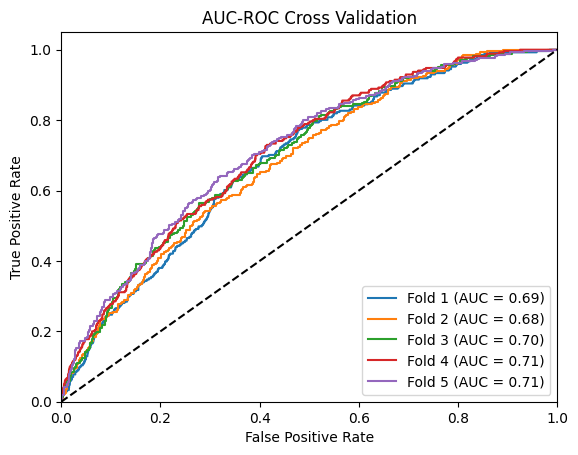

In [27]:
# kfold plotting chatgpt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = xgbc_ntc_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

In [7]:
xgbc_low_v3 = xgbc_model_builder3(n_estimators = 317,
                          max_depth = 9,
                          learning_rate=0.27449790266313423,
                          subsample =  0.6254233401144095,
                          colsample_bytree = 0.8423839899124046,
                          colsample_bylevel = 0.8950877702656028,
                          min_child_weight =72,
                          gamma = 9.766155382529167,
                          reg_alpha = 1,
                          reg_lambda = 32,
                          eta = 0.19526017570266982,
                          random_state = 42)

low
{'colsample_bylevel': 0.8950877702656028, 'colsample_bytree': 0.8423839899124046, 'eta': 0.19526017570266982, 'gamma': 9.766155382529167, 'learning_rate': 0.27449790266313423, 'max_depth': 9, 'min_child_weight': 72, 'n_estimators': 317, 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 32, 'subsample': 0.6254233401144095}

In [8]:
segment

'low_CIBIL'

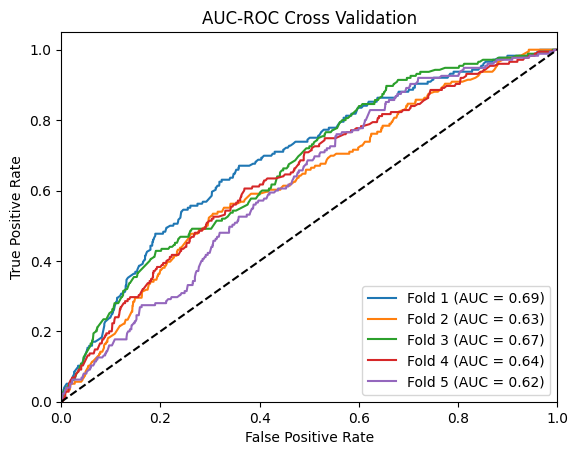

In [11]:
# change segment model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = xgbc_low_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

In [14]:
xgbc_mid_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

mid
{'colsample_bylevel': 0.9299702033681603, 'colsample_bytree': 0.8721230154351118, 'eta': 0.1000998503939086, 'gamma': 0.19897441739799793, 'learning_rate': 0.28267052670545584, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 395, 'random_state': 42, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.8736932106048627}

In [16]:
segment

'mid_CIBIL'

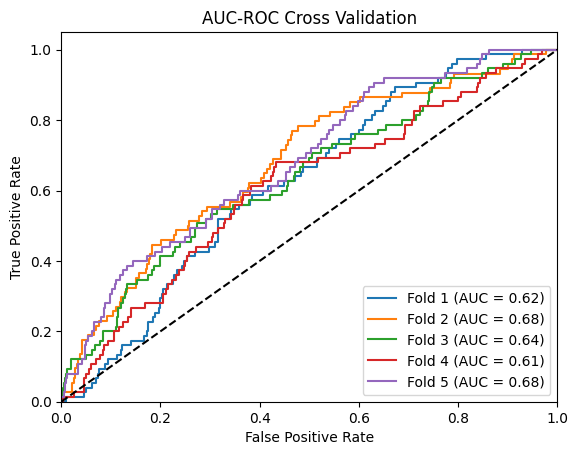

In [17]:
# change segment model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = xgbc_mid_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

In [18]:
xgbc_high_v3 = xgbc_model_builder3(n_estimators = 409,
                          max_depth = 4,
                          learning_rate=0.27280612062363463,
                          subsample =  0.7700623497964979,
                          colsample_bytree = 0.6488152939379115,
                          colsample_bylevel = 0.7200762468698007,
                          min_child_weight =50,
                          gamma = 0.5158278167282759,
                          reg_alpha = 3,
                          reg_lambda = 1,
                          eta = 0.10903538202225403,
                          random_state = 42)

high
{'colsample_bylevel': 0.7200762468698007, 'colsample_bytree': 0.6488152939379115, 'eta': 0.10903538202225403, 'gamma': 0.5158278167282759, 'learning_rate': 0.27280612062363463, 'max_depth': 4, 'min_child_weight': 50, 'n_estimators': 409, 'random_state': 42, 'reg_alpha': 3, 'reg_lambda': 1, 'subsample': 0.7700623497964979}

In [22]:
segment #zz

'high_CIBIL'

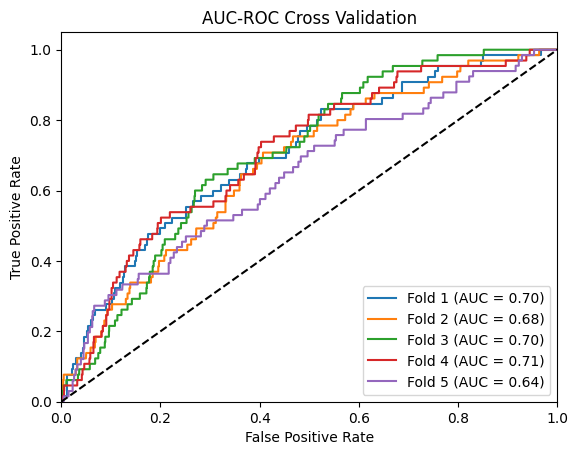

In [23]:
# change segment model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = xgbc_high_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()